In [1]:
import re
from pathlib import Path
import pandas as pd

log_path = Path('/sensei-fs-3/users/lnie/project/paper/figures/raw_data/pilot_study.log')
lines = log_path.read_text().splitlines()

depth_metrics = {}
current_depth = None
current_nodes = None

# Regex patterns
depth_header_re = re.compile(r'^#\s*depth\s+(\d+)\s*-\s*(\d+)\s*nodes', re.I)
omitted_re = re.compile(r'^Average omitted rate.*?:\s*([0-9.]+)%', re.I)
cit_rec_re = re.compile(r'^Average (?:normalized )?citation recall.*?:\s*([0-9.]+)', re.I)
avg_norm_score_re = re.compile(r'^average_normalized_score:\s*([0-9.]+)', re.I)
quality_re = re.compile(r'^(Clarity|Depth|Balance|Breadth|Support|Insightfulness):.*?\(\s*([0-9.]+)\s*/\s*100\s*\)', re.I)

for raw in lines:
    line = raw.strip()
    m = depth_header_re.match(line)
    if m:
        current_depth = int(m.group(1))
        current_nodes = int(m.group(2))
        depth_metrics[current_depth] = {'depth': current_depth, 'nodes': current_nodes}
        continue
    if current_depth is None:
        continue
    m = omitted_re.match(line)
    if m:
        omitted = float(m.group(1))
        depth_metrics[current_depth]['omitted_rate_percent'] = omitted
        depth_metrics[current_depth]['relevance_percent'] = 100.0 - omitted
        continue
    m = cit_rec_re.match(line)
    if m:
        depth_metrics[current_depth]['faithfulness_percent'] = float(m.group(1))
        continue
    m = avg_norm_score_re.match(line)
    if m:
        depth_metrics[current_depth]['average_quality_percent'] = float(m.group(1))
        continue
    m = quality_re.match(line)
    if m:
        name = m.group(1).capitalize()
        value = float(m.group(2))
        depth_metrics[current_depth][name] = value
        continue

# Build DataFrame for plotting
df = pd.DataFrame.from_records(list(depth_metrics.values())).sort_values('depth').reset_index(drop=True)
df


FileNotFoundError: [Errno 2] No such file or directory: '/sensei-fs-3/users/lnie/project/paper/figures/raw_data/pilot_study.log'

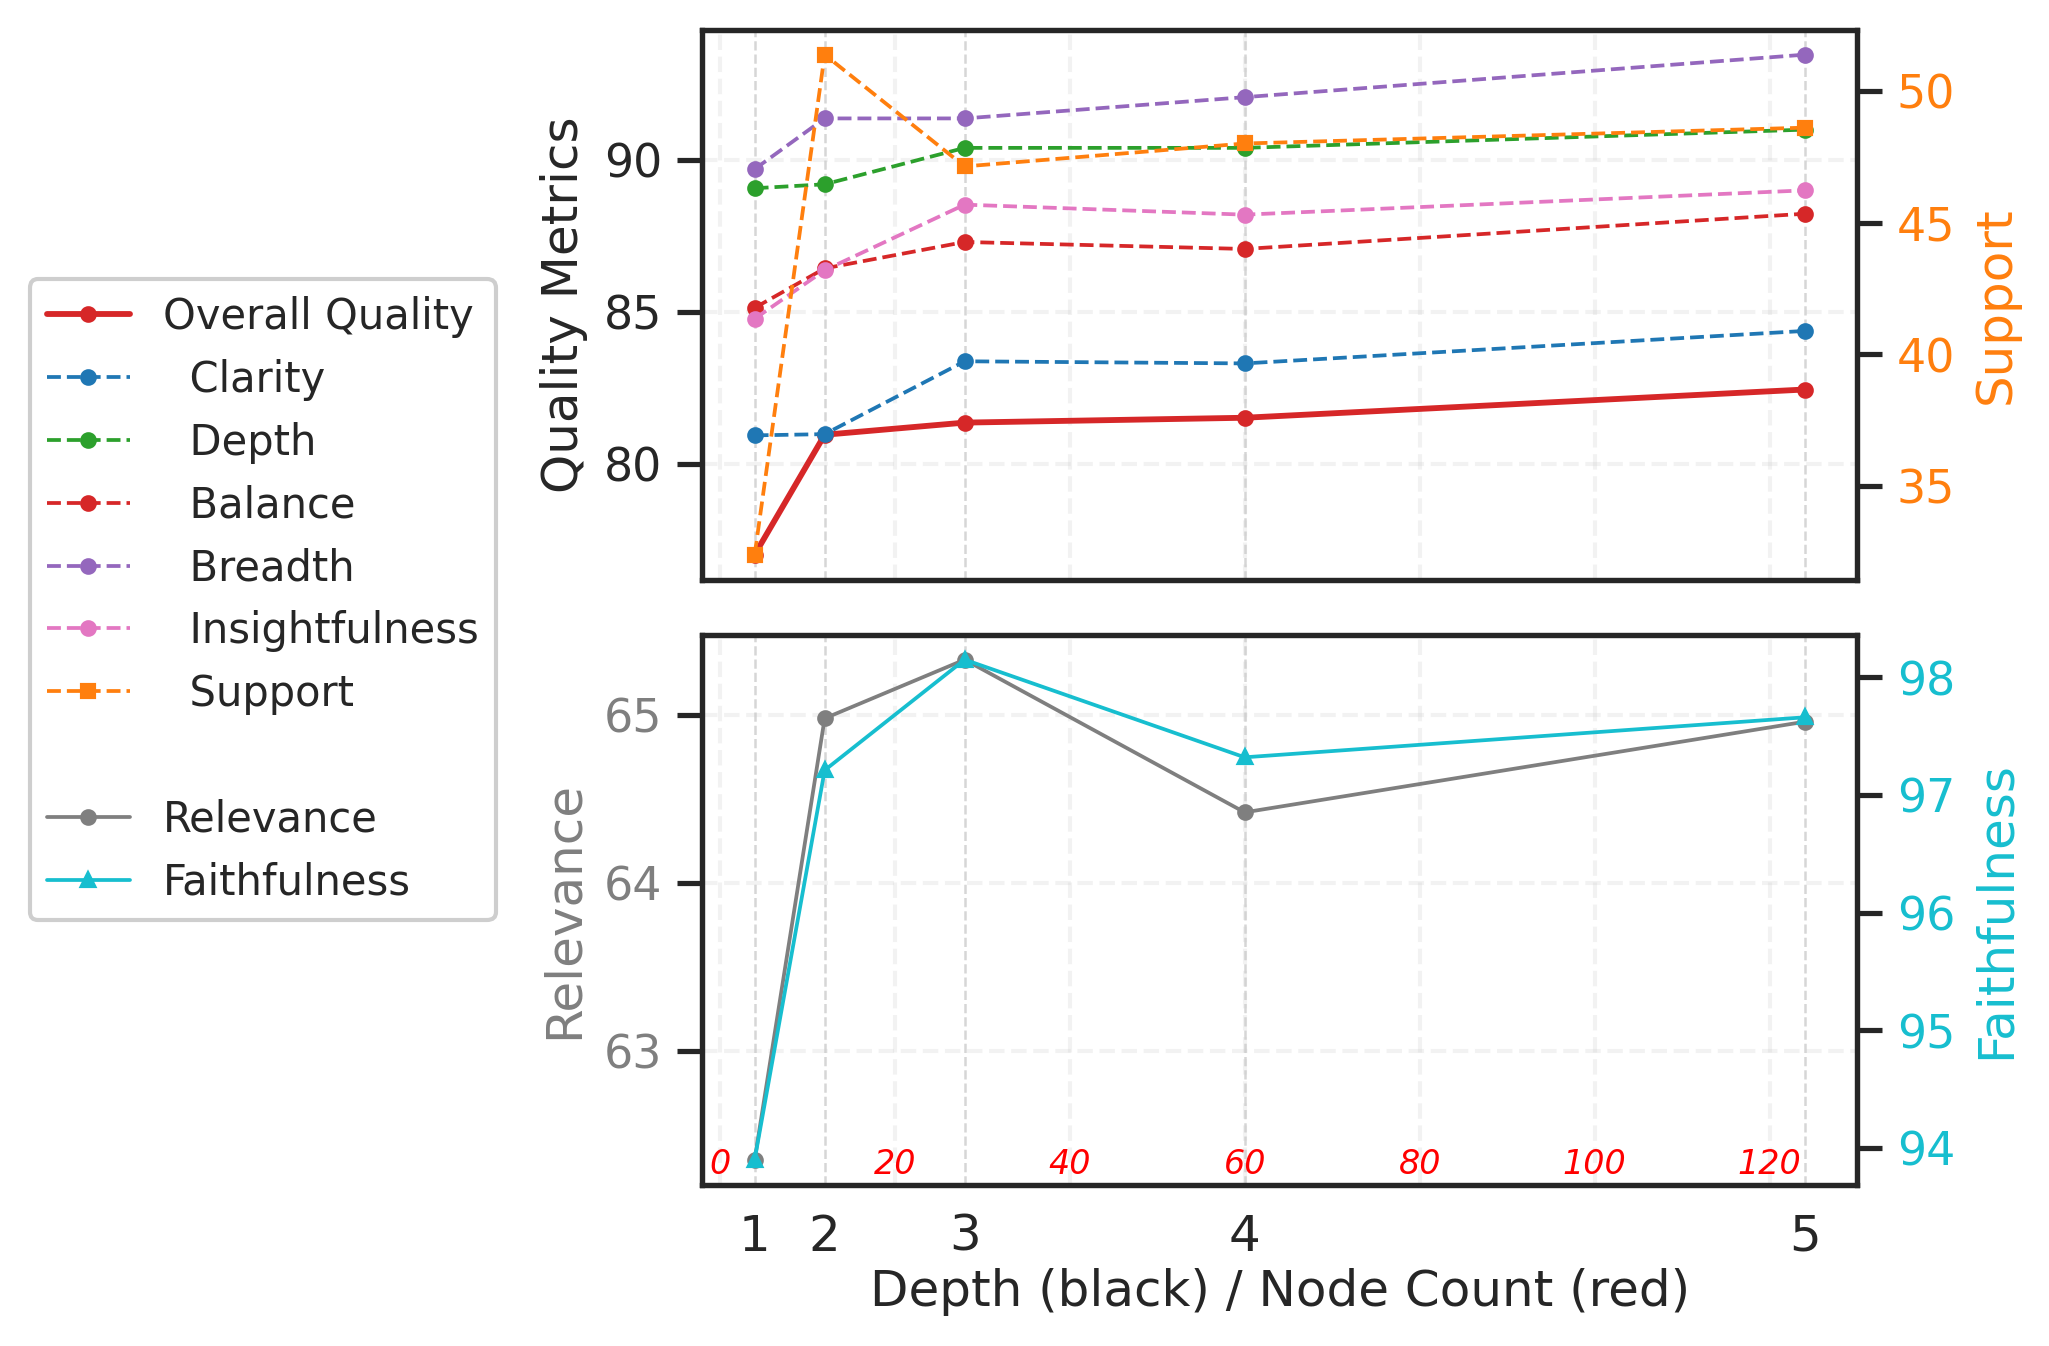

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Toggle: set to True for log-scale x-axis, False for linear
use_log_x = False

# Seaborn styling (keep white background) - increase font scale
sns.set_theme(style='white', context='notebook', font_scale=1.2)

# X as nodes; label ticks by depth
x = df['nodes'].values
depth_values = df['depth'].values
depth_labels = [f'Depth {d}' for d in depth_values]
node_labels = [str(n) for n in x]

# Distinct colors; highlight overall quality in red
palette = sns.color_palette('tab10', 10)
quality_colors = {
    'average_quality_percent': '#d62728',  # red
    'Clarity': palette[0],
    'Depth': palette[2],
    'Balance': palette[3],
    'Breadth': palette[4],
    'Insightfulness': palette[6],
}
support_color = palette[1]
relevance_color = palette[7]
faithfulness_color = palette[9]

# Quality metrics to plot (use percent scales)
quality_columns = ['average_quality_percent', 'Clarity', 'Depth', 'Balance', 'Breadth', 'Support', 'Insightfulness']
present_quality_cols = [c for c in quality_columns if c in df.columns]

fig, axes = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

# Quality panel with dual y-axes (Support on right)
ax_left = axes[0]
primary_quality_cols = [c for c in present_quality_cols if c != 'Support']
for col in primary_quality_cols:
    if col == 'average_quality_percent':
        label = 'Overall Quality'
    else:
        label = '  ' + col  # Add indentation for sub-metrics
    is_overall = (col == 'average_quality_percent')
    ax_left.plot(
        x,
        df[col].values,
        marker='o',
        markersize=3.0,
        linewidth=1.4 if is_overall else 0.9,
        linestyle='-' if is_overall else '--',
        color=quality_colors.get(col, None),
        label=label,
    )
ax_left.set_ylabel('Quality Metrics')
ax_left.grid(True, linestyle='--', alpha=0.25)

ax_right_q = None
if 'Support' in df.columns:
    ax_right_q = ax_left.twinx()
    ax_right_q.plot(
        x,
        df['Support'].values,
        marker='s',
        markersize=3.0,
        linewidth=0.9,
        linestyle='--',
        color=support_color,
        label='  Support',  # Add indentation for sub-metric
    )
    ax_right_q.set_ylabel('Support', color=support_color)
    ax_right_q.tick_params(axis='y', labelcolor=support_color)

# Combine legends from both axes with white background
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = (ax_right_q.get_legend_handles_labels() if ax_right_q else ([], []))
# leg1 = ax_left.legend(handles_left + handles_right, labels_left + labels_right, ncol=2, fontsize=9, frameon=True, fancybox=True)
# leg1.get_frame().set_facecolor('white')
# leg1.get_frame().set_alpha(0.95)

# Relevance & Faithfulness panel with dual y-axes (Relevance left, Faithfulness right)
ax_left2 = axes[1]
if 'relevance_percent' in df.columns:
    ax_left2.plot(x, df['relevance_percent'].values, marker='o', markersize=3.0, linewidth=0.9, color=relevance_color, label='Relevance')
    ax_left2.set_ylabel('Relevance', color=relevance_color)
    ax_left2.tick_params(axis='y', labelcolor=relevance_color)

ax_right2 = ax_left2.twinx()
if 'faithfulness_percent' in df.columns:
    ax_right2.plot(x, df['faithfulness_percent'].values, marker='^', markersize=3.0, linewidth=0.9, color=faithfulness_color, label='Faithfulness')
    ax_right2.set_ylabel('Faithfulness', color=faithfulness_color)
    ax_right2.tick_params(axis='y', labelcolor=faithfulness_color)

ax_left2.set_xlabel('Depth (black) / Node Count (red)', labelpad=20)
ax_left2.grid(True, linestyle='--', alpha=0.25)

# Combine legends for second subplot with white background
handles2_left, labels2_left = ax_left2.get_legend_handles_labels()
handles2_right, labels2_right = ax_right2.get_legend_handles_labels()
# leg2 = ax_left2.legend(handles2_left + handles2_right, labels2_left + labels2_right, fontsize=9, frameon=True, fancybox=True)
# leg2.get_frame().set_facecolor('white')
# leg2.get_frame().set_alpha(0.95)

# Use node counts for positions but label ticks with depth numbers
axes[1].set_xticks(x)
axes[1].set_xticklabels(node_labels, color='red', fontsize=10, style='italic')
# Move node tick labels uniformly slightly above the axis using padding (in points)
axes[1].tick_params(axis='x', which='major', pad=-15)


# Apply x-axis scale consistently across primary and twin axes
def _apply_xscale(ax):
    if use_log_x:
        ax.set_xscale('log')
        ax.set_xlim(left=min(x) * 0.9, right=max(x) * 1.1)
    else:
        ax.set_xscale('linear')
        span = max(x) - min(x)
        pad = 0.05 * span if span > 0 else 1.0
        ax.set_xlim(left=min(x) - pad, right=max(x) + pad)

for a in [ax_left, ax_left2]:
    _apply_xscale(a)
if ax_right_q is not None:
    _apply_xscale(ax_right_q)
_apply_xscale(ax_right2)

# Depth vertical dashed guides and depth labels on both subplots
for ax in [ax_left, ax_left2]:
    for xi in x:
        ax.axvline(x=xi, color='#cccccc', linestyle='--', linewidth=0.6, alpha=0.8, zorder=0)
    
    # Add depth labels above the x-axis for the bottom subplot only
    if ax is ax_left2:
        ymin, ymax = ax.get_ylim()
        ytext = ymin - 0.05 * (ymax - ymin)  # Position below x-axis
        for xi, d in zip(x, depth_values):
            ax.text(xi, ytext, f'{int(d)}', ha='center', va='top', fontsize=14)

# Merge all legends and place a single legend to the left of the figure
# Collect handles and labels from first subplot (quality metrics)
handles_subplot1, labels_subplot1 = [], []
for a in [ax_left, ax_right_q]:
    if a is None:
        continue
    h, l = a.get_legend_handles_labels()
    handles_subplot1.extend(h)
    labels_subplot1.extend(l)

# Collect handles and labels from second subplot (relevance/faithfulness)
handles_subplot2, labels_subplot2 = [], []
for a in [ax_left2, ax_right2]:
    if a is None:
        continue
    h, l = a.get_legend_handles_labels()
    handles_subplot2.extend(h)
    labels_subplot2.extend(l)

# Create proxy handles with visual indentation for sub-metrics
handles_subplot1_final = []
for handle, label in zip(handles_subplot1, labels_subplot1):
    if label.startswith('  '):
        # Create indented proxy handle for sub-metrics
        proxy = plt.Line2D([0], [0], color=handle.get_color(), 
                          linestyle=handle.get_linestyle(), 
                          linewidth=handle.get_linewidth(),
                          marker=handle.get_marker(),
                          markersize=handle.get_markersize())
        handles_subplot1_final.append(proxy)
    else:
        handles_subplot1_final.append(handle)

# Combine with spacing between subplots
handles_all = handles_subplot1_final + [plt.Line2D([0], [0], color='none')] + handles_subplot2
labels_all = labels_subplot1 + [''] + labels_subplot2
# Remove per-axes legends if they exist
try:
    leg1.remove()
except Exception:
    pass
try:
    leg2.remove()
except Exception:
    pass
fig_leg = fig.legend(handles_all, labels_all, loc='center left', bbox_to_anchor=(0.02, 0.5), frameon=True, fancybox=True, fontsize=12)
fig_leg.get_frame().set_facecolor('white')
fig_leg.get_frame().set_alpha(0.95)
# Make room on the left for the external legend
fig.subplots_adjust(left=0.35, hspace=0.1)

# set figure size and dpi
fig.set_size_inches(7, 5)
fig.set_dpi(300)


plt.show()

# save the figure
fig.savefig('../pilot_study_depth.pdf', dpi=300)
